### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    if device.name == 'GPU:0':
        tf.config.experimental.set_memory_growth(device, True)
        tf.config.set_logical_device_configuration(
            device, [tf.config.LogicalDeviceConfiguration(memory_limit=1024*6)])
        break


### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255, validation_split=0.6)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


In [6]:
test_dataset = test_datagen.flow_from_directory(directory = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 766 images belonging to 4 classes.


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


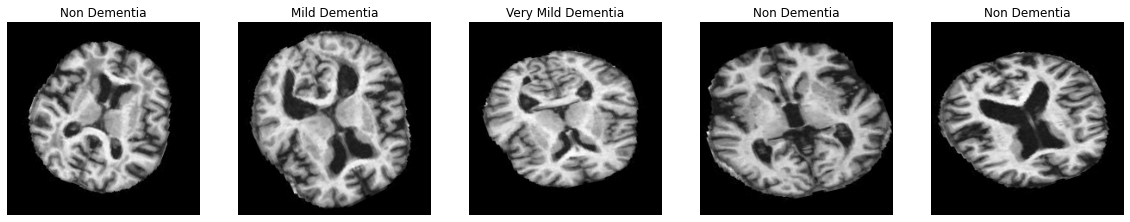

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [8]:
# Model Initialization

base_model = DenseNet121(input_shape = (224,224,3), 
                         include_top = False,
                         weights = "imagenet")

29089792/29084464 [==============================] - 0s 0us/step


In [9]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [10]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation = 'softmax'))

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc'),
                       tensorflow.keras.metrics.BinaryAccuracy(name = 'accuracy'),
                       tensorflow.keras.metrics.Recall(name='recall'),
                       tensorflow.keras.metrics.Precision(name = 'precision')],
              optimizer=OPT)

In [12]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.3479 - auc: 0.7822 - accuracy: 0.7648 - recall: 0.4678 - precision: 0.5337
Epoch 00001: val_auc improved from -inf to 0.76757, saving model to ./best_weights.hdf5
33/33 [==============================] - 78s 2s/step - loss: 1.3479 - auc: 0.7822 - accuracy: 0.7648 - recall: 0.4678 - precision: 0.5337 - val_loss: 2.7866 - val_auc: 0.7676 - val_accuracy: 0.7598 - val_recall: 0.5132 - val_precision: 0.5198
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.1332 - auc: 0.8190 - accuracy: 0.7801 - recall: 0.4978 - precision: 0.5689
Epoch 00002: val_auc did not improve from 0.76757
33/33 [==============================] - 56s 2s/step - loss: 1.1332 - auc: 0.8190 - accuracy: 0.7801 - recall: 0.4978 - precision: 0.5689 - val_loss: 2.5196 - val_auc: 0.7526 - val_accuracy: 0.7441 - val_recall: 0.4673 - val_precision: 0.4878
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 1.0393 - auc: 0.83

In [14]:
_ = model.evaluate(test_dataset)

6/6 [==============================] - 8s 1s/step - loss: 1.3694 - auc: 0.8570 - accuracy: 0.8006 - recall: 0.5849 - precision: 0.6046
